# Combine Time Series and Downsample

In [1]:
import pandas as pd
import os
import csv
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

We have distinct segments of sensor data.

In [2]:
metadata = pd.read_csv('metadata.csv')
metadata

segment        waterbody  \
0     Annapolis_Annapolis Basin_Cornwallis_2.0_2020-...  Annapolis Basin   
1     Annapolis_Annapolis Basin_Lobster Ledge_2.0_20...  Annapolis Basin   
2     Annapolis_Annapolis Basin_Lobster Ledge_6.0_20...  Annapolis Basin   
3     Annapolis_Annapolis Basin_Lobster Ledge_4.0_20...  Annapolis Basin   
4     Annapolis_Annapolis Basin_Cornwallis_1.0_2020-...  Annapolis Basin   
...                                                 ...              ...   
1076  Yarmouth_Careys Cove_Yarmouth Bar_5.0_2023-08-...      Careys Cove   
1077  Yarmouth_Lamonts Cove_Short Beach_5.0_2023-08-...     Lamonts Cove   
1078  Yarmouth_Lamonts Cove_Short Beach_10.0_2023-08...     Lamonts Cove   
1079  Yarmouth_Lamonts Cove_Short Beach_2.0_2023-08-...     Lamonts Cove   
1080  Yarmouth_Lamonts Cove_Short Beach_15.0_2023-08...     Lamonts Cove   

            station  depth (m) deployment_start_date (UTC)  \
0        Cornwallis        2.0        2020-06-11T00:00:00Z   
1     Lobster Ledge        2.0        2020-06-11T00:00:00Z   
2     Lobster Ledge        6.0        2020-06-11T00:00:00Z   
3     Lobster Ledge        4.0        2020-06-11T00:00:00Z   
4        Cornwallis        1.0        2020-06-11T00:00:00Z   
...             ...        ...                         ...   
1076   Yarmouth Bar        5.0        2023-08-03T00:00:00Z   
1077    Short Beach        5.0        2023-08-03T00:00:00Z   
1078    Short Beach       10.0        2023-08-03T00:00:00Z   
1079    Short Beach        2.0        2023-08-03T00:00:00Z   
1080    Short Beach       15.0        2023-08-03T00:00:00Z   

     deployment_end_date (UTC)  
0         2020-11-22T00:00:00Z  
1         2020-11-22T00:00:00Z  
2         2020-11-22T00:00:00Z  
3         2020-11-22T00:00:00Z  
4         2020-11-22T00:00:00Z  
...                        ...  
1076      2024-08-07T00:00:00Z  
1077      2024-08-07T00:00:00Z  
1078      2024-08-07T00:00:00Z  
1079      2024-08-07T00:00:00Z  
1080      2024-08-07T00:00:00Z  

[1081 rows x 6 columns]

Sensor are deployed many different depths in the water column

In [3]:
metadata['depth (m)'].unique()

array([ 2.  ,  6.  ,  4.  ,  1.  ,  1.3 ,  0.5 ,  1.5 ,  0.4 ,  0.8 ,
        1.6 , 16.  , 15.  , 14.  ,  0.  ,  5.  ,  7.  , 30.  , 18.  ,
       10.  , 20.  ,  3.  ,  3.5 ,  0.41, 26.  , 25.  , 75.  , 40.  ,
       50.  , 22.  , 28.  , 36.  ,  9.  , 60.  , 44.  , 24.  , 27.  ,
       12.  , 21.  , 16.5 ,  8.  , 17.5 , 37.  , 11.  , 13.  ,  4.5 ])

But most often, there are standard depths that are most often used:

In [4]:
metadata['depth (m)'].value_counts().head(15)

depth (m)
2.0     195
5.0     184
10.0    156
15.0    132
20.0     93
1.0      50
30.0     35
25.0     25
0.5      18
40.0     16
4.0      14
3.0      13
1.5      10
8.0      10
27.0     10
Name: count, dtype: int64

Let's group these observation segments into more limited number of study sites where the waterbody, station, and depth are the same even if the sensor itself is replaced.

In [5]:
depths_list = [2.0, 5.0, 10.0, 15.0, 20.0]
study_sites = metadata[metadata['depth (m)'].isin(depths_list)][['waterbody', 'station', 'depth (m)']].drop_duplicates()
study_sites.reset_index(drop=True, inplace=True)

In [6]:
study_sites

waterbody            station  depth (m)
0       Annapolis Basin         Cornwallis        2.0
1       Annapolis Basin      Lobster Ledge        2.0
2          Grahams Cove      Captains Pond        2.0
3       St. Georges Bay  St. Georges Bay S       15.0
4    Antigonish Harbour               1442        2.0
..                  ...                ...        ...
196         Careys Cove       Yarmouth Bar        5.0
197        Lamonts Cove        Short Beach        5.0
198        Lamonts Cove        Short Beach       10.0
199        Lamonts Cove        Short Beach        2.0
200        Lamonts Cove        Short Beach       15.0

[201 rows x 3 columns]

For any of these study sites we can consider all of the observational segements at that station and depth.

segment       waterbody  \
179  Guysborough_Chedabucto Bay_Tickle Island 1_20....  Chedabucto Bay   
268  Guysborough_Chedabucto Bay_Tickle Island 1_20....  Chedabucto Bay   
317  Guysborough_Chedabucto Bay_Tickle Island 1_20....  Chedabucto Bay   
390  Guysborough_Chedabucto Bay_Tickle Island 1_20....  Chedabucto Bay   

             station  depth (m) deployment_start_date (UTC)  \
179  Tickle Island 1       20.0        2020-02-24T00:00:00Z   
268  Tickle Island 1       20.0        2020-10-21T00:00:00Z   
317  Tickle Island 1       20.0        2021-08-25T00:00:00Z   
390  Tickle Island 1       20.0        2022-07-27T00:00:00Z   

    deployment_end_date (UTC)  
179      2020-10-21T00:00:00Z  
268      2021-08-25T00:00:00Z  
317      2022-07-27T00:00:00Z  
390      2023-07-05T00:00:00Z

Text(0, 0.5, 'temperature (degrees_Celsius)')

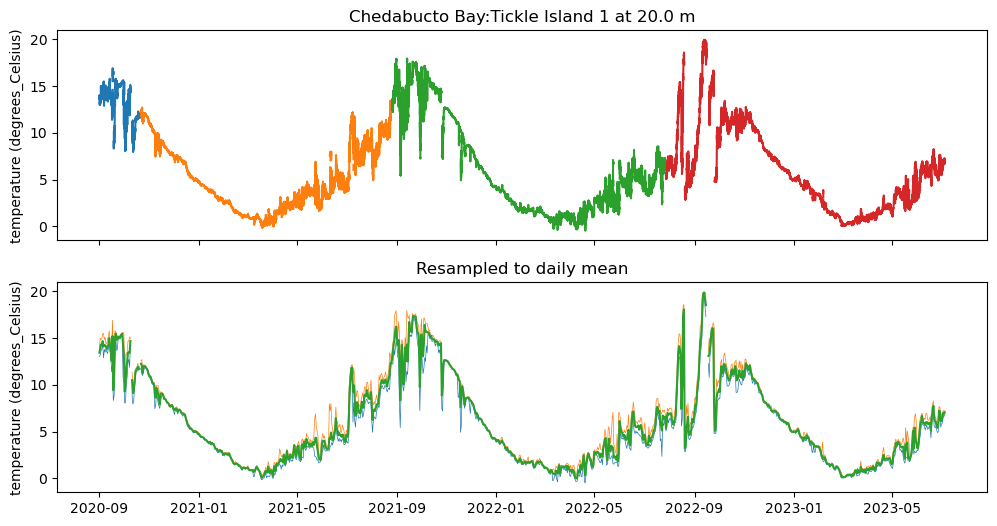

In [7]:
study_site = study_sites.iloc[37]

subset = metadata[ (metadata['waterbody'] == study_site['waterbody']) &  (metadata['station'] == study_site['station']) & (metadata['depth (m)'] == study_site['depth (m)'])]
display(subset)

fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)

variable = 'temperature (degrees_Celsius)'
qc_flag = 'qc_flag_temperature'

series_segments = []
for index, row in subset.iterrows():

    csvfile = f"segments/{row['segment']}.csv"
       
    series = pd.read_csv(csvfile, index_col='time (UTC)', parse_dates=True)
    series.sort_index(inplace=True)

    # blank out observations that do not pass QC
    series[series[qc_flag] != 'Pass'] = np.nan
    series = series.drop(columns=[qc_flag])
    
    ax[0].plot(series.index, series[variable])
    
    ax[0].set_ylabel(variable)
    ax[0].set_title(f'{study_site.waterbody}:{study_site.station} at {study_site['depth (m)']} m')

    if series.count()[variable] > 0:
        series_segments.append(series)

series_df = pd.concat(series_segments)
series_df.sort_index(inplace=True)

ax[1].set_title('Resampled to daily mean')
daily_series_df = series_df.resample('D').min()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='min', linewidth=0.5)
daily_series_df = series_df.resample('D').max()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='max', linewidth=0.5)
daily_series_df = series_df.resample('D').mean()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='mean')

ax[1].set_ylabel(variable)

At the time scale of four years, daily means are sufficient to see the cycle. The plot above shows the daily minimum and daily maximum.


## Combine segments into time series

We aggregate together these different segments from different deployments (and possibly different sensor) to create a complete daily time series at each station and depth in our study area:

In [8]:
start_date = "2020-09-01"
end_date = "2024-08-31"

daily_time_index = pd.date_range(start=start_date, end=end_date, freq='D')

all_timeseries = []

for study_site_id in tqdm(study_sites.index):

    study_site = study_sites.iloc[study_site_id]
    #print(f'[{study_site_id}] {study_site.waterbody}:{study_site.station} at {study_site['depth (m)']} m')
    study_site_name = f'{study_site.waterbody.replace(' ','')}_{study_site.station.replace(' ','')}_{study_site['depth (m)']:.0f}'
    
    subset = metadata[ (metadata['waterbody'] == study_site['waterbody']) &  (metadata['station'] == study_site['station']) & (metadata['depth (m)'] == study_site['depth (m)'])].copy()
    
    segments = []
    for segment_id, row in subset.iterrows():

        csvfile = f"segments/{row['segment']}.csv"
        segment = pd.read_csv(csvfile, index_col='time (UTC)', parse_dates=True)
        
        segment.sort_index(inplace=True)

        # blank out observations that do not pass QC
        segment[segment[qc_flag] != 'Pass'] = np.nan
        segment = segment.drop(columns=[qc_flag])

        if segment.count()[variable] > 0:
            segments.append(segment)

    if len(segments) > 0:
        
        timeseries = pd.concat(segments)
        timeseries.columns = [study_site_id]
        
        timeseries.sort_index(inplace=True)

        daily_timeseries = timeseries.resample('D').mean()

        all_timeseries.append(daily_timeseries)

dataset = pd.concat(all_timeseries, axis=1)

  0%|          | 0/201 [00:00<?, ?it/s]

This is our temperature dataset.  It also define the starting point for reproducing this analysis with a different data set.  We have measurements on same time resolution for many different measurements.  Each column in the dataset represents a different measurement.  We use `NaN` to represent daily measurements that are missing.

The goal of imputation is to make a good estimate of what values to replace those `NaN` that, while still an estimate, are justifiable.

In [9]:
dataset

0          1    2          3          4    \
time (UTC)                                                                   
2020-09-01 00:00:00+00:00  14.945833  14.294167  NaN        NaN        NaN   
2020-09-02 00:00:00+00:00  14.995833  14.304385  NaN        NaN        NaN   
2020-09-03 00:00:00+00:00  14.975000  14.355667  NaN        NaN        NaN   
2020-09-04 00:00:00+00:00  14.833333  14.236365  NaN        NaN        NaN   
2020-09-05 00:00:00+00:00  14.925000  14.328073  NaN        NaN        NaN   
...                              ...        ...  ...        ...        ...   
2024-08-27 00:00:00+00:00        NaN        NaN  NaN  18.478261  22.546385   
2024-08-28 00:00:00+00:00        NaN        NaN  NaN  17.700000  21.905760   
2024-08-29 00:00:00+00:00        NaN        NaN  NaN  19.087500  19.500187   
2024-08-30 00:00:00+00:00        NaN        NaN  NaN  19.958333  19.538146   
2024-08-31 00:00:00+00:00        NaN        NaN  NaN  20.100000        NaN   

                                 5    6    7          8          9    ...  \
time (UTC)                                                            ...   
2020-09-01 00:00:00+00:00        NaN  NaN  NaN  14.979208  13.096833  ...   
2020-09-02 00:00:00+00:00        NaN  NaN  NaN  15.469177  13.148625  ...   
2020-09-03 00:00:00+00:00        NaN  NaN  NaN  15.290702  13.163687  ...   
2020-09-04 00:00:00+00:00        NaN  NaN  NaN  14.986469  13.192083  ...   
2020-09-05 00:00:00+00:00        NaN  NaN  NaN  15.342979  13.224823  ...   
...                              ...  ...  ...        ...        ...  ...   
2024-08-27 00:00:00+00:00  22.584802  NaN  NaN        NaN        NaN  ...   
2024-08-28 00:00:00+00:00  22.017229  NaN  NaN        NaN        NaN  ...   
2024-08-29 00:00:00+00:00  19.225979  NaN  NaN        NaN        NaN  ...   
2024-08-30 00:00:00+00:00  19.245250  NaN  NaN        NaN        NaN  ...   
2024-08-31 00:00:00+00:00        NaN  NaN  NaN        NaN        NaN  ...   

                           191  192  193  194  195  196  197  198  199  200  
time (UTC)                                                                   
2020-09-01 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2020-09-02 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2020-09-03 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2020-09-04 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2020-09-05 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2024-08-27 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-08-28 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-08-29 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-08-30 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-08-31 00:00:00+00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1461 rows x 201 columns]

## Missing Data

How much of this dataset is actually missing?

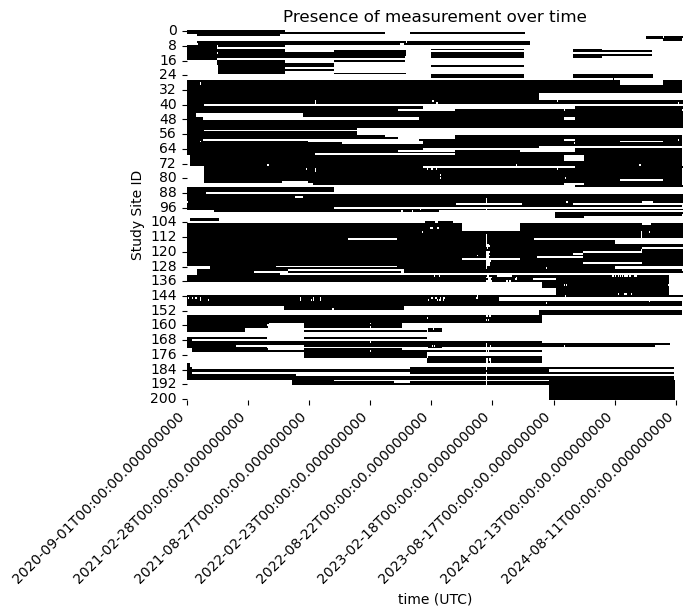

In [10]:
non_missing_data = ~dataset.isna()

import seaborn as sns
from matplotlib.dates import DateFormatter

plt.figure()
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

plt.ylabel('Study Site ID')
plt.title(f'Presence of measurement over time')

# Rotating the time axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

Some of our study site have very limited measurements at any time. We focus the problem more narrowly and ask what is the best estimate of the missing data when there is at least 50% of the observations available at a study site.

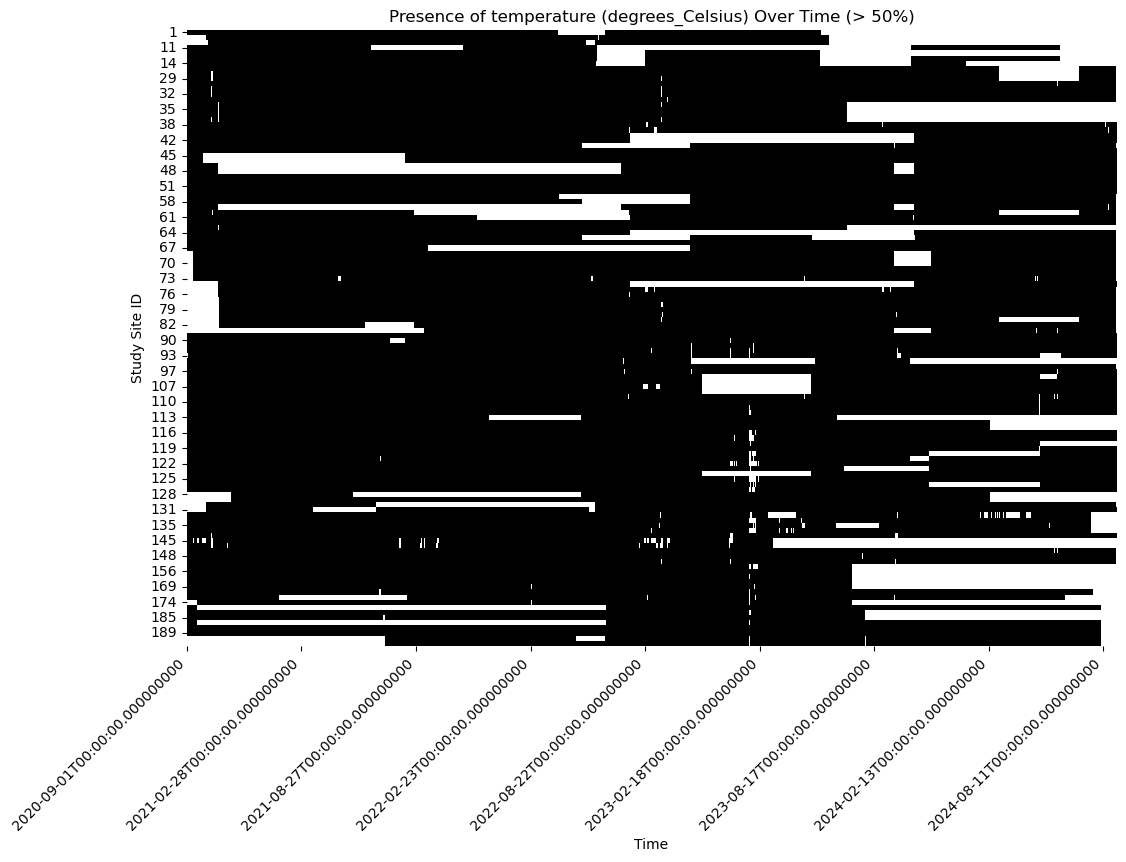

In [11]:
# Calculate the percentage of non-missing data for each study site
non_missing_percentage = dataset.notna().mean() * 100

# Filter study sites with at least 50% non-missing data
selected_sites = non_missing_percentage[non_missing_percentage >= 50].index
df_selected = dataset[selected_sites]

# Creating a boolean DataFrame where True indicates non-missing data
non_missing_data = ~df_selected.isna()

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

# Formatting the time axis labels
date_format = DateFormatter('%Y-%m-%d %H:%M')
#plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Time')
plt.ylabel('Study Site ID')
plt.title(f'Presence of {variable} Over Time (> 50%)')

# Rotating the time axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


Our objective is to fill in the gaps in this dataset.

We save this dataset for subsequent analysis.  While in this case study, the data happens to be temperature data the overall process should be applicable to any dataset in this form.

In [12]:
df_selected.to_csv('dataset.csv')

And let's save the information about where each of those selected study sites.

In [13]:
study_sites_selected = study_sites.iloc[selected_sites]
study_sites_selected.to_csv('study_sites.csv')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
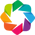

In [14]:
import holoviews as hv
hv.extension('bokeh')

In [15]:
df_selected.columns = df_selected.columns.astype(str)

In [16]:
dictionary = {i: hv.Curve(df_selected[str(i)], 
                          label=f"{study_sites_selected.loc[i, 'waterbody']} - {study_sites_selected.loc[i, 'station']} ({study_sites_selected.loc[i, 'depth (m)']}m)")
                for i in study_sites_selected.index }
hv.HoloMap(dictionary, kdims='Study Site').opts(aspect=2)

:HoloMap   [Study Site]
   :Curve   [time (UTC)]   (192)